En el trabajo de Arturo se menciona la ecuacion de Volterra 

In [1]:
from dolfin import *
from dolfin_adjoint import *
import numpy as np
set_log_level(LogLevel.WARNING)
import pickle
from scipy.linalg import block_diag
import scipy

In [345]:
T=0.5
dt=0.01
N = int(tau/dt)
sigma = lambda t: 1-(1/4)*np.cos(4*np.pi*t/T)
print(N)

tau=0.02
eigenmode=0

control = pickle.load(open(f"../step_1/NullControls/Eigen_{eigenmode}_tau_{int(tau/dt)}/control.pickle", "rb"))
control

2


{'control': array([ 0.       , -0.0731413, -0.0731413, ..., -0.0731413, -0.0731413,
         0.       ]),
 'x': array([0.     , 0.     , 0.03125, ..., 0.96875, 1.     , 1.     ]),
 'y': array([1.     , 0.96875, 1.     , ..., 0.     , 0.03125, 0.     ])}

In [346]:
L0 = np.array([
    [1, 0],
    [0, sigma(0)]
])

ell_0 = block_diag(*[L0 for _ in range(N+1)])
ell_0

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.75, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.75, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.75]])

In [347]:
def M_ts(t, s):
    return np.array([
        [0, 1],
        [sigma(s-t), (sigma(s-t+dt)-sigma(s-t))/dt]
    ])

raw_em_N = np.array([
    [M_ts(dt*i, dt*j) if (i==j or j==N) and i!=N else 2*M_ts(dt*i, dt*j) if i<j and i!=N else 0*M_ts(dt*i, dt*j) for j in range(N+1)]
    for i in range(N+1)
])
em_N = np.concatenate(raw_em_N[0], axis=1)
for i in range(1, raw_em_N.shape[0]):
    em_N = np.concatenate([em_N, np.concatenate(raw_em_N[i], axis=1)])
em_N


array([[ 0.        ,  1.        ,  0.        ,  2.        ,  0.        ,
         1.        ],
       [ 0.75      ,  0.78542097,  1.51570842,  4.61382405,  0.78092333,
         3.68345132],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ],
       [ 0.        , -0.        ,  0.75      ,  0.78542097,  0.75785421,
         2.30691203],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , -0.        ,  0.        , -0.        ,  0.        ,
         0.        ]])

In [348]:
A = ell_0 + (dt/2) * em_N

In [350]:
b

array([0., 0., 0., 0., 0., 0.])

In [349]:
mask = np.array([i%2==0 for i in range((N+1)*2)])
theta_dots = []
theta_dt_dots = []

for ix in range(control["x"].shape[0]):
    x_ix, y_ix = control["x"][ix], control["y"][ix]
    control_ix = control["control"][ix]

    v_tilde = np.array([
        [0],
        [control_ix]
    ])

    raw_b = np.array([
        v_tilde
        for _ in range(N+1)
    ])
    b = np.concatenate(raw_b, axis=0).flatten()

    theta_ix = scipy.linalg.solve(A, b)

    
    theta_dots.append(theta_ix[mask])
    theta_dt_dots.append(theta_ix[~mask])

theta_dots = np.array(theta_dots)
theta_dt_dots = np.array(theta_dt_dots)

In [315]:
it = 15
theta_it = Function(V)
theta_it.vector()[:] = theta_dots[:, it]
theta_it

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 53), FiniteElement('Lagrange', triangle, 1)), 60)

In [316]:
import matplotlib.pyplot as plt

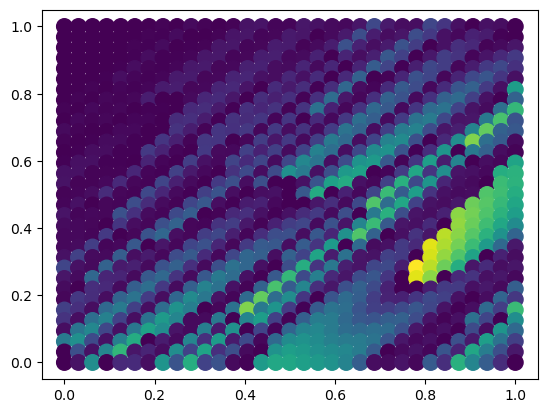

In [317]:
plt.scatter(control["x"], control["y"], c=theta_it.vector()[:], s=125)

In [5]:
eigenmode=3 #<----

mesh = UnitSquareMesh(32, 32)
V = FunctionSpace(mesh, "Lagrange", 1)
tol = 1e-14
# Defining bounday conditions

def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS or x[1] > 1.0 - DOLFIN_EPS

uD = Constant(0.0)
bc = DirichletBC(V, uD, boundary)
f_dofs = V.dofmap().dofs()

T=0.5
dt=0.01
sigma = lambda t: 1-(1/4)*np.cos(4*np.pi*t/T)

def M_ts(t, s):
    return np.array([
        [0, 1],
        [sigma(s-t), (sigma(s-t+dt)-sigma(s-t))/dt]
    ])

for z in range(1, int(T/dt)+1):
    tau=dt*z
    control = pickle.load(open(f"../step_1/NullControls/Eigen_{eigenmode}_tau_{int(tau/dt)}/control.pickle", "rb"))

    L0 = np.array([
        [1, 0],
        [0, sigma(0)]
    ])


    N = int(tau/dt)
    print(N)

    ell_0 = block_diag(*[L0 for _ in range(N+1)])

    raw_em_N = np.array([
        [M_ts(dt*i, dt*j) if (i==j or j==N) and i!=N else 2*M_ts(dt*i, dt*j) if i<j and i!=N else 0*M_ts(dt*i, dt*j) for j in range(N+1)]
        for i in range(N+1)
    ])
    em_N = np.concatenate(raw_em_N[0], axis=1)
    for i in range(1, raw_em_N.shape[0]):
        em_N = np.concatenate([em_N, np.concatenate(raw_em_N[i], axis=1)])

    A = ell_0 + (dt/2) * em_N

    mask = np.array([i%2==0 for i in range((N+1)*2)])
    theta_dots = []
    theta_dt_dots = []

    for ix in range(control["x"].shape[0]):
        x_ix, y_ix = control["x"][ix], control["y"][ix]
        control_ix = control["control"][ix]

        v_tilde = np.array([
            [0],
            [control_ix]
        ])

        raw_b = np.array([
            v_tilde
            for _ in range(N+1)
        ])
        b = np.concatenate(raw_b, axis=0).flatten()

        theta_ix = scipy.linalg.solve(A, b)


        theta_dots.append(theta_ix[mask])
        theta_dt_dots.append(theta_ix[~mask])

    theta_dots = np.array(theta_dots)
    theta_dt_dots = np.array(theta_dt_dots)

    file = File(f'Theta/Theta_eigen_{eigenmode}_tau_{int(tau/dt)}/theta.pvd')
    file_dt = File(f'Theta/Theta_eigen_{eigenmode}_tau_{int(tau/dt)}/theta_dt.pvd')

    for it in range(N+1):

        theta_it = Function(V)
        theta_it.vector()[f_dofs] = theta_dots[:, it]

        theta_it.rename('theta','theta')
        File(f'Theta/Theta_eigen_{eigenmode}_tau_{int(tau/dt)}/theta_{it}.xml')  << theta_it
        file << (theta_it, it)
        
        
        theta_dt_it = Function(V)
        theta_dt_it.vector()[f_dofs] = theta_dt_dots[:, it]

        theta_dt_it.rename('theta_dt','theta_dt')
        File(f'Theta/Theta_eigen_{eigenmode}_tau_{int(tau/dt)}/theta_dt_{it}.xml')  << theta_dt_it
        file_dt << (theta_dt_it, it)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
28
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
